Copyright (C) Egon Kidmose 2015-2018

This file is part of lstm-rnn-correlation.

lstm-rnn-correlation is free software: you can redistribute it and/or
modify it under the terms of the GNU Lesser General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

lstm-rnn-correlation is distributed in the hope that it will be
useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public
License along with lstm-rnn-correlation. If not, see
<http://www.gnu.org/licenses/>.

# Label alerts with incident description

 1. Loads alerts
 2. Load incident descriptions
 3. Label alerts according incident descriptions, default to benign
 4. Plot/analyse for validation

In [1]:
"""


From snort logs to labelled snort logs for ML consumptions.
"""
from lstm_rnn_tied_weights import util
from lstm_rnn_tied_weights import snort

import glob
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import cPickle as pickle
from distutils.version import LooseVersion
from functools import partial

# matplotlib
try: # might, might not have x available
    import os
    os.environ['DISPLAY']
except KeyError:
    import matplotlib
    matplotlib.use('Agg')
try: # might, might not be notebook
    %matplotlib inline
except NameError:
    pass
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import dask.dataframe as ddf
from dask.multiprocessing import get as dget

/home/egk/git-reps/lstm-rnn-correlation/venv/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
logger = util.get_logger('preprocessing-cic-ids-2017')

output_prefix = os.path.join('output', 'preprocessing-'+util.get_runid(), util.get_runid()+'-')
if not os.path.exists('output'):
    os.mkdir('output')
if not os.path.exists(os.path.dirname(output_prefix)):
    os.mkdir(os.path.dirname(output_prefix))

seed = 1531857839 # Unix time at time of writing
def rndseed():
    global seed
    seed += 1
    return seed

Output prefix: log/preprocessing-cic-ids-2017-20180717-222632-egk-aau-laptop/20180717-222632-egk-aau-laptop-


## Load alerts

In [3]:
# importing data
alertfiles = glob.glob('../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/*.pcap.out')
alerts = None

for fn in sorted(alertfiles):
    logger.debug('Loading %s' % fn)
    with open(fn) as f:
        df = pd.DataFrame(f.readlines(),columns=['line'])
        df = df.join(pd.DataFrame(
            map(snort.parse_line, df.line),
            columns=['ts', 'rid', 'msg', 'prio', 'proto', 'srcip', 'srcport', 'dstip', 'dstport'],
        ))
    alerts = pd.concat([alerts, df])
    logger.info("Loaded %d alerts from %s" % (len(df), fn,))

logger.info("All data loaded, %d total alerts" % len(alerts))

Loaded 61491 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Friday-WorkingHours.pcap.out
Loaded 46530 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Monday-WorkingHours.pcap.out
Loaded 30237 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Thursday-WorkingHours.pcap.out
Loaded 34580 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Tuesday-WorkingHours.pcap.out
Loaded 259022 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Wednesday-workingHours.pcap.out
All data loaded, 431860 total alerts


In [4]:
# Snort truncates year and off by 3 hours, fix:
alerts.ts = alerts.ts + (datetime(2017, 1, 1) - datetime(1900, 1, 1)) # increment year to 2017
alerts.ts = alerts.ts - pd.to_timedelta('3h') # Add three hours to move alerts to 9:00-17:00. Dunno why. Maybe tz in snort...
alerts = alerts.sort_values('ts').reset_index(drop=True)

## Load incident descriptions

In [5]:
# load incident descriptions, extracted from website text
inc_desc = pd.read_csv(
    'incident_descriptions.csv', 
    parse_dates=['Start', 'Stop'],
    date_parser = lambda x: pd.datetime.strptime(x, '%d-%m-%y %H:%M')
)
inc_desc['Stop'] = inc_desc['Stop'].dt.floor('min') + timedelta(minutes=1)
inc_desc['Interval'] = inc_desc[['Start', 'Stop',]].apply(
    lambda d: pd.Interval(d[0], d[1], closed='both'), 
    axis=1
)


## Label alerts with incident descriptions

In [6]:
# For each alert, get a list of labels
get_labels = lambda ts: inc_desc[inc_desc.Interval.apply(lambda iv: ts in iv)].Label.unique()
dask_ts = ddf.from_pandas(alerts.ts, npartitions=4*3-1)
alerts['Labels'] = dask_ts.map_partitions(lambda series: series.apply((lambda el: get_labels(el)))).compute(get=dget)

/home/egk/git-reps/lstm-rnn-correlation/venv/local/lib/python2.7/site-packages/dask/base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


In [7]:
print('Number of alerts receiving N unique labels, when labelling by time interval alone')
hist_alerts = alerts.Labels.apply(len).value_counts().sort_index()
hist_alerts

Number of alerts receiving N unique labels, when labelling by time interval alone


0    138747
1    293113
Name: Labels, dtype: int64

In [8]:
# Convert label list to single label
assert hist_alerts[0] + hist_alerts[1] == alerts.shape[0], "Not all alerts received 0 or 1 labels"

alerts['Label'] = alerts.Labels.apply(
    lambda l: 'BENIGN' if len(l) == 0 else l[0]
)

assert set(inc_desc.Label.unique()) - set(alerts.Label.unique()) == set(), "Some labels missing in alerts"

In [9]:
alerts.Label.value_counts()

DoS Hulk                      224684
BENIGN                        138747
DDoS                           24174
PortScan                        6798
FTP-Patator                     6197
SSH-Patator                     5613
Bot                             5294
DoS Slowhttptest                4553
Infiltration                    4421
Web Attack - Brute Force        3366
DoS GoldenEye                   2973
DoS slowloris                   2250
Heartbleed                      1361
Web Attack - XSS                1095
Web Attack - Sql Injection       334
Name: Label, dtype: int64

In [10]:
# Create direction agnostic view of alerts 
#  - Exclude benign
#  - Each alert is counted twice
diragLeft = alerts[alerts.Label != 'BENIGN'].rename(columns={'dstip':'ip'})
diragLeft['dstip'] = alerts[alerts.Label != 'BENIGN'].dstip
diragRight = alerts[alerts.Label != 'BENIGN'].rename(columns={'srcip':'ip'})
diragRight['srcip'] = alerts[alerts.Label != 'BENIGN'].srcip

dirag = pd.concat([diragLeft, diragRight])

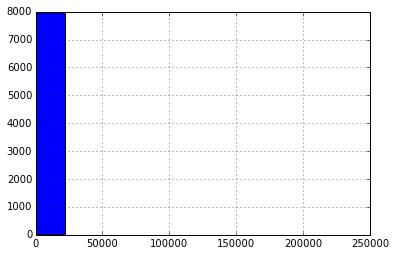

In [11]:
# Analyse each IPs involvement in incident by alert counts
# We ignore flow direction, counting each alert for both srcip and dstip
involvement = dirag.groupby(['Label', 'ip']).ip.agg('count').sort_values(ascending=False)

involvement.hist()

In [12]:
# how many IPs are involved in exactly N alerts:
involvement.value_counts().head()

1    3138
2    1630
3     680
4     526
5     281
Name: ip, dtype: int64

## Analyse alerts over time

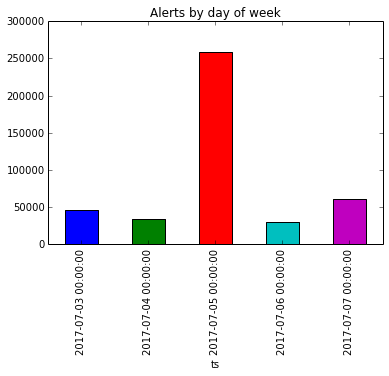

In [13]:
alerts.groupby([alerts.ts.dt.floor('d')]).count().ts.plot(kind="bar")
plt.title('Alerts by day of week')

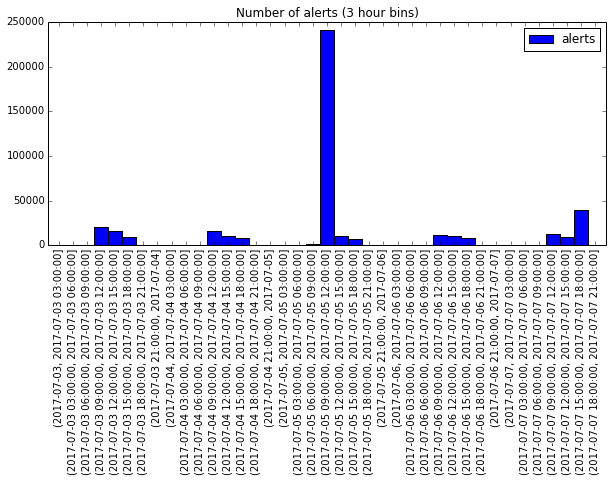

In [14]:
pd.DataFrame(
    pd.cut(
        alerts.ts, bins=pd.date_range('2017-07-03', freq='3H', periods=40)
    ).value_counts().rename('alerts').sort_index(),
).plot(kind='bar', width=1, figsize=(10,4))
plt.title('Number of alerts (3 hour bins)')

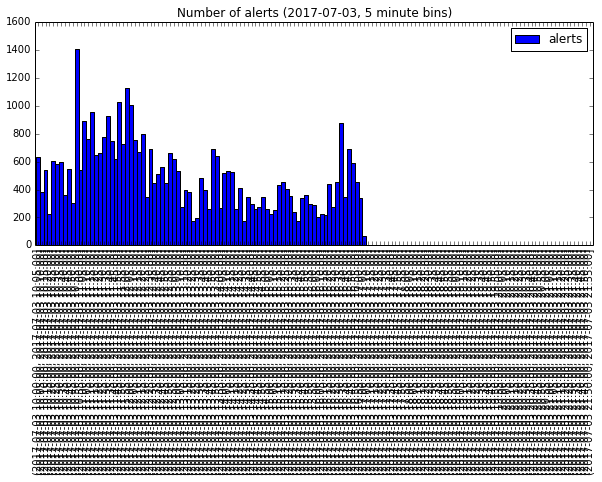

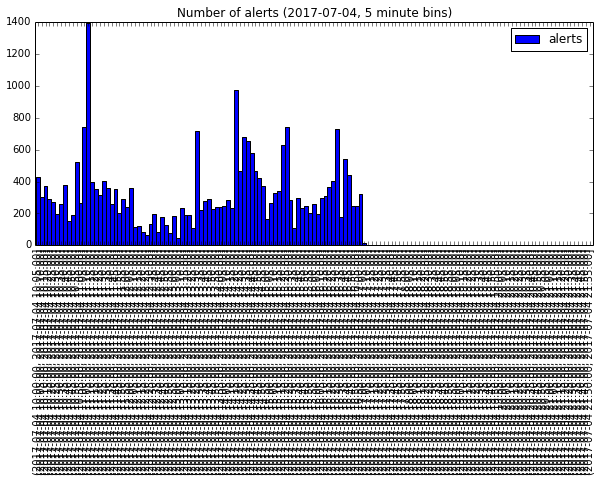

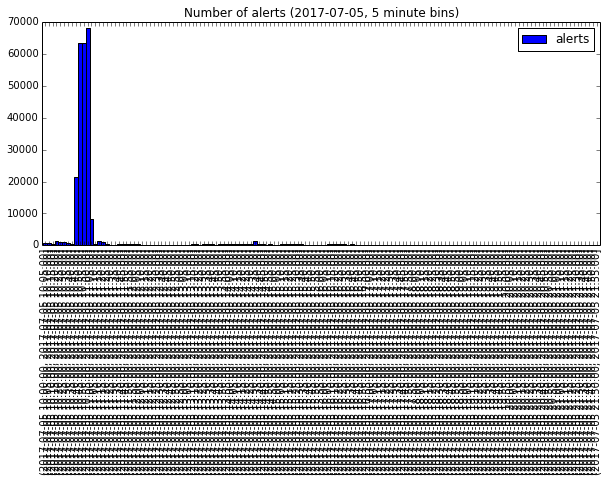

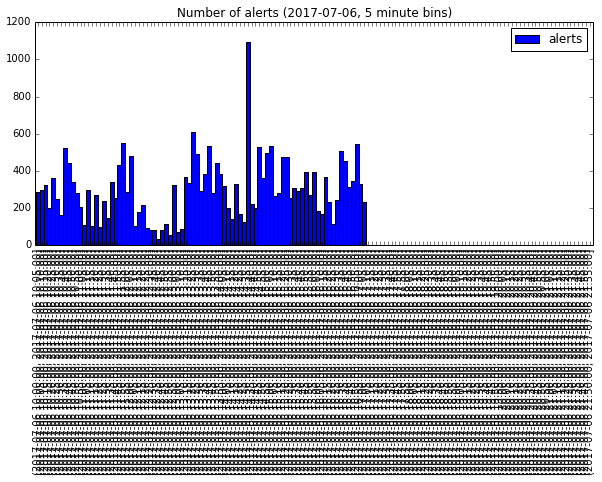

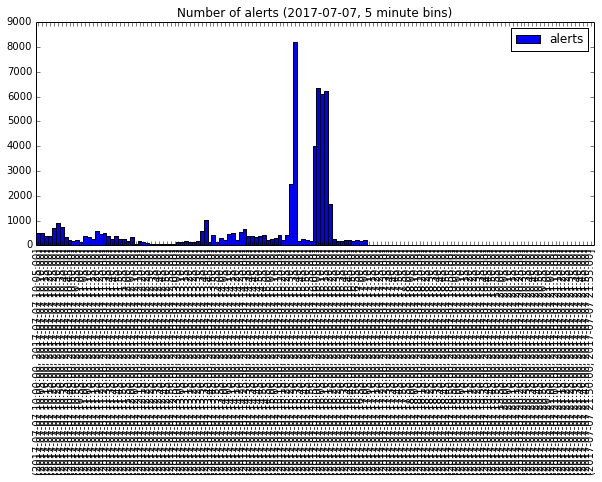

In [15]:
for day in range(5):
    start = '2017-07-%.2d' % (day + 3)
    pd.DataFrame(
        pd.cut(
            alerts.ts, bins=pd.date_range(start + ' 10:00', freq='300s', periods=0.5*24*60./5)
        ).value_counts().rename('alerts').sort_index(),
    ).plot(kind='bar', width=1, figsize=(10,4))
    plt.title('Number of alerts (%s, 5 minute bins)' % start)

/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


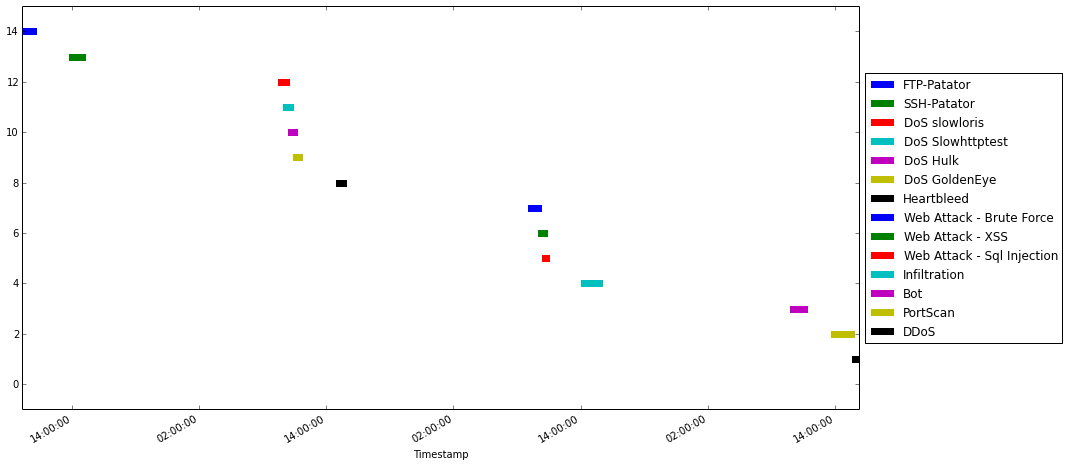

In [16]:
# plot description from webpage

# Flat (i.e. start and stop in same column)
inc_desc_flat = pd.concat([
    inc_desc.rename(columns={'Start': 'Timestamp'}),
    inc_desc.rename(columns={'Stop': 'Timestamp'}),
])

begin = inc_desc_flat.groupby('Label').Timestamp.min().sort_values()
end =  inc_desc_flat.groupby('Label').Timestamp.max()

# create an index containing all min and max timestamps
df_periods = pd.DataFrame(index=pd.Index(pd.concat([begin, end,])))

# create a (constant) Series for each series
for idx, d in enumerate(begin.index):
    df_periods[d] = df_periods.index.to_series().apply(
        lambda x: begin.shape[0] - idx if x >= begin[d] and x <= end[d] else np.NaN
    )

ax = df_periods.plot(
    ylim=[-1, begin.shape[0]+1],
    xlim=[begin.min(), end.max()],
    linewidth=7,
    legend=True,
    figsize=(15, 8),
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


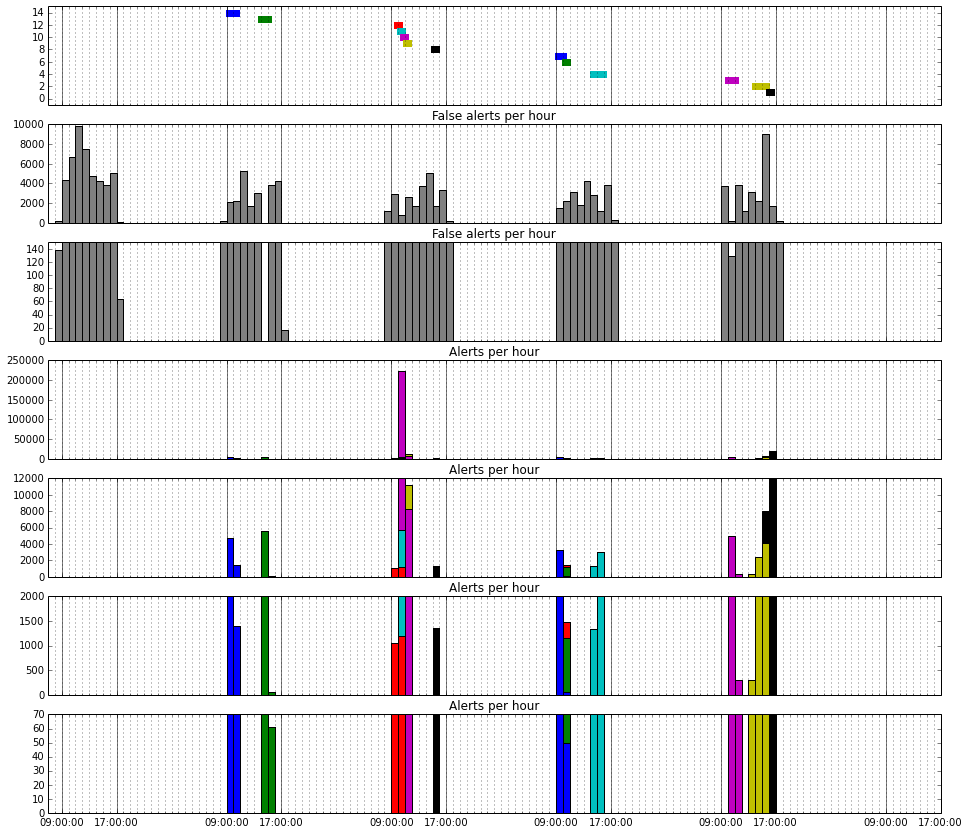

In [17]:
# A hell of a lot of plotting, by time

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

fig, axes = plt.subplots(
    nrows=7, 
    figsize=(16, 16),
    sharex=True,
)

# plot description from webpage

# Flat (i.e. start and stop in same column)
inc_desc_flat = pd.concat([
    inc_desc.rename(columns={'Start': 'Timestamp'}),
    inc_desc.rename(columns={'Stop': 'Timestamp'}),
])

begin = inc_desc_flat.groupby('Label').Timestamp.min().sort_values()
end =  inc_desc_flat.groupby('Label').Timestamp.max()

# create an index containing all min and max timestamps
df_periods = pd.DataFrame(index=pd.Index(pd.concat([begin, end,])))

# create a (constant) Series for each series
for idx, d in enumerate(begin.index):
    df_periods[d] = df_periods.index.to_series().apply(
        lambda x: begin.shape[0] - idx if x >= begin[d] and x <= end[d] else np.NaN
    )

df_periods.plot(
    ylim=[-1, begin.shape[0]+1],
    xlim=[begin.min(), end.max()],
    linewidth=7,
    ax=axes[0],
    legend=False,
)

# Store colors for reuse
colors = {line.get_label(): line.get_color() for line in axes[0].lines}
colors['BENIGN'] = '#808080' # Benign is not in rules..

# False alert timestamps binned
alert_bins = alerts[alerts.Label == 'BENIGN'].reset_index().set_index('ts').resample('1H').count()['index'].rename('alerts')
ax = axes[1].bar(
    alert_bins.index,
    alert_bins,
    color=colors['BENIGN'],
    width=1./24, # x axis is float of days
)
axes[1].set_title('False alerts per hour')

# False alert timestamps binned - short y axis
alert_bins = alerts[alerts.Label == 'BENIGN'].reset_index().set_index('ts').resample('1H').count()['index'].rename('alerts')
ax = axes[2].bar(
    alert_bins.index,
    alert_bins,
    color=colors['BENIGN'],
    width=1./24, # x axis is float of days
)
axes[2].set_title('False alerts per hour')
axes[2].set_ylim((0, 150))

# Alert timestamps binned - By label
alert_bins = pd.DataFrame([
    alerts[alerts.Label == desc].reset_index().set_index('ts').resample('1H').count()['index'].rename(desc)
    for desc in alerts.Label.unique() if 'BENIGN' not in desc
])

for ii, desc in enumerate(alert_bins.index):
    axes[3].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=colors[desc],
    )
axes[3].set_title('Alerts per hour')

# Alert timestamps binned - By label - short y axis
for ii, desc in enumerate(alert_bins.index):
    axes[4].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=colors[desc],
    )
axes[4].set_title('Alerts per hour')
axes[4].set_ylim((0, 12000))

# Alert timestamps binned - By label - shortER y axis
for ii, desc in enumerate(alert_bins.index):
    axes[5].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=colors[desc],
    )
axes[5].set_title('Alerts per hour')
axes[5].set_ylim((0, 2000))

# Alert timestamps binned - By label - EVEN shortER y axis
for ii, desc in enumerate(alert_bins.index):
    axes[6].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=colors[desc],
    )
axes[6].set_title('Alerts per hour')
axes[6].set_ylim((0, 70))

# General
for ax in axes:
    ax.grid(axis='x', which='minor')
    ax.grid(axis='x', which='major', linestyle='-')

ax = axes[5]
plt.sca(ax)

ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[9, 17]))

datemin = pd.to_datetime('07-03-2017 7:00')
datemax = pd.to_datetime('07-08-2017 17:00')
ax.set_xlim(datemin, datemax)

plt.xticks(rotation=90)
None

In [18]:
def get_data_overview(data):
    df_inc_cnt = pd.DataFrame(data.groupby(['Label']).size().rename('inc_cnt').reset_index())
    df_inc_cnt['inc_cnt_pct'] = df_inc_cnt['inc_cnt']/data.count()[0]*100

    df_inc_prio_cnt = pd.DataFrame(
        pd.merge(data, df_inc_cnt, on='Label').groupby(['Label', 'prio', 'inc_cnt']
    ).size().rename('inc_prio_cnt').reset_index())
    df_inc_prio_cnt['inc_prio_cnt_pct'] = df_inc_prio_cnt['inc_prio_cnt']/df_inc_prio_cnt['inc_cnt']*100

    df_overview = pd.merge(df_inc_cnt, df_inc_prio_cnt).groupby(['Label', 'prio']).first().reset_index()

    tot_prio = data.groupby(['prio']).size().rename('inc_prio_cnt')
    df_tot = pd.DataFrame(tot_prio)
    df_tot['inc_prio_cnt_pct'] = df_tot['inc_prio_cnt']/data.count()[0]*100
    df_tot['inc_cnt'] = data.count()[0]
    df_tot['inc_cnt_pct'] = 100
    df_tot['Label'] = 'total'

    df_overview = pd.concat([df_overview.reset_index(), df_tot.reset_index()])\
        .groupby(['Label', 'inc_cnt', 'inc_cnt_pct', 'prio', ])\
        .first().drop('index', 1)

    return df_overview

logger.info('Overview of labelled data')
df_overview = get_data_overview(alerts)
logger.debug(df_overview.to_latex())
logger.debug(df_overview.to_string())
df_overview

Overview of labelled data


inc_prio_cnt  \
Label                      inc_cnt inc_cnt_pct prio                 
BENIGN                     138747  32.127773   1               82   
                                               2            96956   
                                               3            41709   
Bot                        5294    1.225860    1               54   
                                               2             3098   
                                               3             2142   
DDoS                       24174   5.597647    1                3   
                                               2              727   
                                               3            23444   
DoS GoldenEye              2973    0.688418    1                1   
                                               2              898   
                                               3             2074   
DoS Hulk                   224684  52.027046   2            98698   
                                               3           125986   
DoS Slowhttptest           4553    1.054277    1                3   
                                               2             2548   
                                               3             2002   
DoS slowloris              2250    0.521002    1                2   
                                               2             1513   
                                               3              735   
FTP-Patator                6197    1.434956    1                5   
                                               2             3598   
                                               3             2594   
Heartbleed                 1361    0.315148    1                1   
                                               2              898   
                                               3              462   
Infiltration               4421    1.023711    1                2   
                                               2             3021   
                                               3             1398   
PortScan                   6798    1.574121    1                4   
                                               2             4977   
                                               3             1817   
SSH-Patator                5613    1.299727    1                4   
                                               2             3892   
                                               3             1717   
Web Attack - Brute Force   3366    0.779419    1                2   
                                               2             1914   
                                               3             1450   
Web Attack - Sql Injection 334     0.077340    1               10   
                                               2              197   
                                               3              127   
Web Attack - XSS           1095    0.253554    2              688   
                                               3              407   
total                      431860  100.000000  1              173   
                                               2           223623   
                                               3           208064   

                                                     inc_prio_cnt_pct  
Label                      inc_cnt inc_cnt_pct prio                    
BENIGN                     138747  32.127773   1             0.059100  
                                               2            69.879709  
                                               3            30.061191  
Bot                        5294    1.225860    1             1.020023  
                                               2            58.519078  
                                               3            40.460899  
DDoS                       24174   5.597647    1             0.012410  
                                               2             3.007363  
                    

## Split alerts

In [19]:
logger.info('Splitting data')

# Shuffle
np.random.seed(rndseed())
alerts.reindex(np.random.permutation(alerts.index))

alerts = alerts.reset_index().reset_index().set_index('index')
alerts['cut'] = alerts.level_0 % 10
alerts.drop('level_0', axis=1, inplace=True)

alert_count = pd.DataFrame(alerts.groupby('cut').size().rename('Alert count')).T
logger.info('Alert count by cuts: \n' + alert_count.to_string())
alert_count


Splitting data
Alert count by cuts: 
cut              0      1      2      3      4      5      6      7      8      9
Alert count  43186  43186  43186  43186  43186  43186  43186  43186  43186  43186


cut,0,1,2,3,4,5,6,7,8,9
Alert count,43186,43186,43186,43186,43186,43186,43186,43186,43186,43186


## Save alerts

In [20]:
logger.info('Saving alerts')
alerts.to_csv(
    output_prefix + 'alerts.csv',
    columns=['Label', 'line', 'cut'],
    index=False,
)
logger.info('Saved alerts')

Saving alerts
Saved alerts


In [21]:
logger.info('Saving test alerts')
alerts_test = pd.DataFrame()
for (i, c) in [(i, c) for i in alerts['Label'].unique() for c in alerts['cut'].unique()]:
    alerts_test = pd.concat([
        alerts_test,
        alerts[(alerts['Label'] == i) & (alerts['cut'] == c)].head(100)
    ])
alerts_test.to_csv(
    output_prefix + 'alerts.test.csv',
    columns=['Label', 'line', 'cut'],
    index=False,
)
logger.info('Saved test alerts')

Saving test alerts
Saved test alerts


In [22]:
logger.info('Completed')

Completed
